# MLP
Mean RCI over 14 cell lines.

This notebook uses
mRNA, all transcripts, no middle-exclusion train, no middle-exclusion test, 0 threshold, learning module, cross-validation.

In [1]:
SEED = 45
import tensorflow as tf
tf.random.set_seed(SEED) 
tf.keras.backend.set_floatx('float32')
import numpy as np
np.random.seed(SEED) 
from datetime import datetime
print(datetime.now())

2023-05-01 14:09:24.661257


In [2]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
    sys.path.append('/content/drive/My Drive/Colab Notebooks')
except:
    IN_COLAB = False
    DATA_DIR="/"
    MODEL_DIR="/"
print(DATA_DIR)
SAVE_MODEL_FILENAME = None # 'MLP_mRNA'
SAVE_DESCRIM_FILENAME = None # 'GMM_mRNA'
LOAD_MODEL_FILENAME = None # 'MLP_mRNA.0.0.model'
LOAD_DESCRIM_FILENAME = None # 'GMM_mRNA.0.0.pickle'

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from learning import DataLoader, CrossValidator, Separator, ModelBuilder

K=5
ALPHABET=4**K + 1
EPOCHS=300 
EMBED_DIMEN = 4 # arbitrary hyperparameter
RCI_THRESHOLD_MECHANISM = 'ZERO'   # 'RCI_GMM' 'ZERO' 'THE_MEAN'
RCI_THRESHOLD_VALUE = 0  # use -1 for lncRNA, use 0 for mRNA
BREAK = False   # optionally break after first fold
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
MIDDLE_LOW          = -1   # -2 for lncRNA, -1 for mRNA
MIDDLE_HIGH         =  1   #  0 for lncRNA, +1 for mRNA

REPEATS = 2
FOLDS = 5

Python 3.10.11
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.pc_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.pc_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.all_pc_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.all_pc_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1]  # H1.hESC   
print('Exclusions',EXCLUSIONS)

Exclusions [1]


In [6]:
from tensorflow import keras
from keras import models
import pickle

def save_model(model, discriminator, filename1, filename2):
    filepath = MODEL_DIR + filename1
    model.save(filepath)
    print('Saved model 1 to',filepath)
    filepath = MODEL_DIR + filename2
    pickle.dump(discriminator, open(filepath, 'wb'))
    print('Saved model 2 to',filepath)

def load_model(filename1, filename2):
    filepath = MODEL_DIR + filename1
    model = keras.models.load_model(filepath)
    print('Loaded model 1 from',filepath)
    filepath = MODEL_DIR + filename2
    discriminator = pickle.load(open(filepath, 'rb'))        
    print('Loaded model 2 from',filepath)
    return model, discriminator
        

2023-05-01 14:09:45.717452
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.pc_RCI.all_cell_lines.csv
Number of RCI values loaded 13663
Num RCI: 13663
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.all_pc_transcripts.csv
Loaded 131213 sequences.

Training # 1 1
2023-05-01 14:14:09.200404
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.1.validation_genes.txt
Discriminator ZERO 0
Train 1:0 47990:56355 45.99%
Computed class weights: {0: 0.9257829828764085, 1: 1.0871535736611795}
Valid 1:0 12044:14824 44.83%
FIT


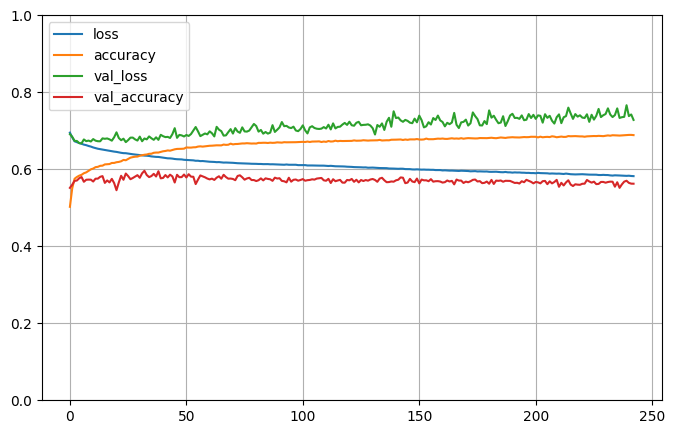


Testing # 1 1
2023-05-01 15:35:42.174841
PREDICT
Test 1:0 12044:14824 44.83%
Predict 1:0 10089:16779 37.55%
Test sizes (26868, 1025) (26868,)
Distrib of scores: 0.46977404 mean 0.21247089 std
Range of scores: 0.01993189 to 0.9625986
Score threshold 0.5
Confusion matrix
 [[10144  4680]
 [ 6635  5409]]
Normalized matrix
 [[0.3775495  0.1741849 ]
 [0.24694804 0.20131755]]
Extreme scores correct, pos:neg 3439 3997
Extreme scores incorrect pos:neg 2757 1854


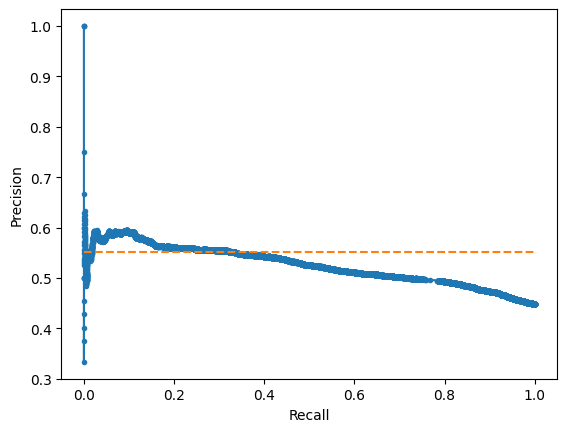

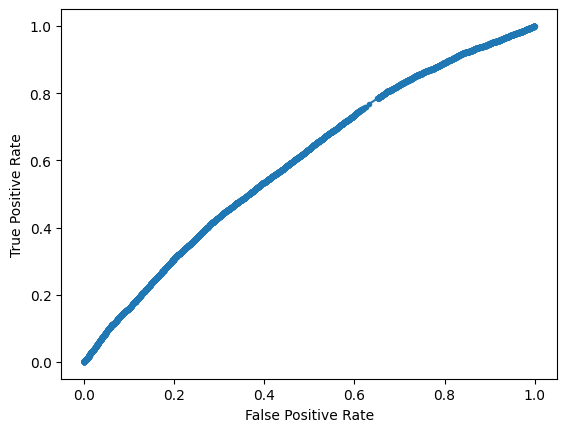

Accuracy: 57.89% Precision: 53.61% Recall: 44.91%
F1: 48.88% MCC: 0.1370
AUPRC: 52.56% AUROC: 59.72%
 accuracy [57.88670537442311]
 precision [53.612845673505795]
 recall [44.91032879442046]
 F1 [48.87724212714047]
 MCC [0.1369978124731362]
 AUPRC [52.55649786149218]
 AUROC [59.722168483952444]

Training # 1 2
2023-05-01 15:35:46.529999
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.2.validation_genes.txt
Discriminator ZERO 0
Train 1:0 47393:57556 45.16%
Computed class weights: {0: 0.9117120717214539, 1: 1.107220475597662}
Valid 1:0 12641:13623 48.13%
FIT


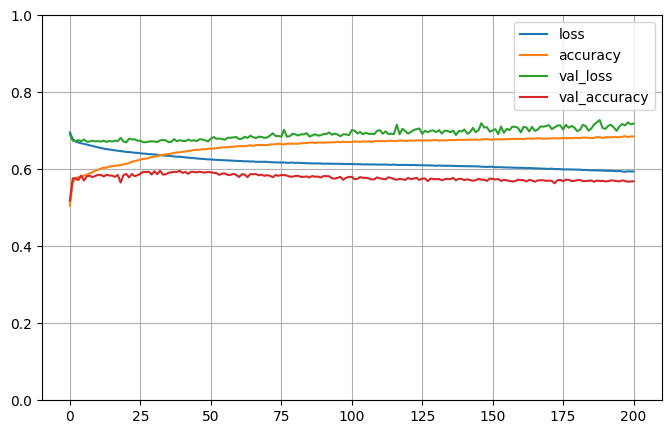


Testing # 1 2
2023-05-01 16:49:16.194972
PREDICT
Test 1:0 12641:13623 48.13%
Predict 1:0 9897:16367 37.68%
Test sizes (26264, 1025) (26264,)
Distrib of scores: 0.47922993 mean 0.20626612 std
Range of scores: 0.07427883 to 0.872854
Score threshold 0.5
Confusion matrix
 [[9485 4138]
 [6882 5759]]
Normalized matrix
 [[0.36114072 0.15755407]
 [0.26203168 0.21927353]]
Extreme scores correct, pos:neg 3970 3917
Extreme scores incorrect pos:neg 2482 1884


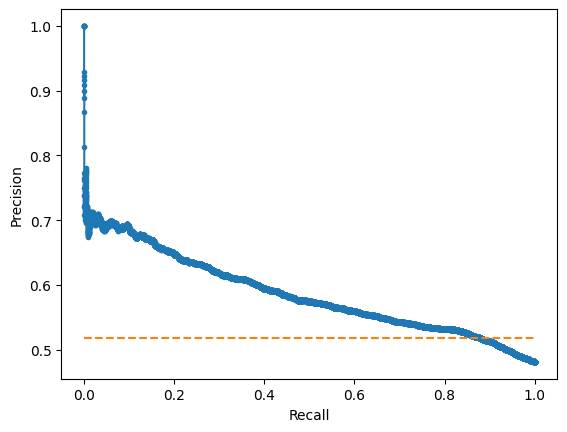

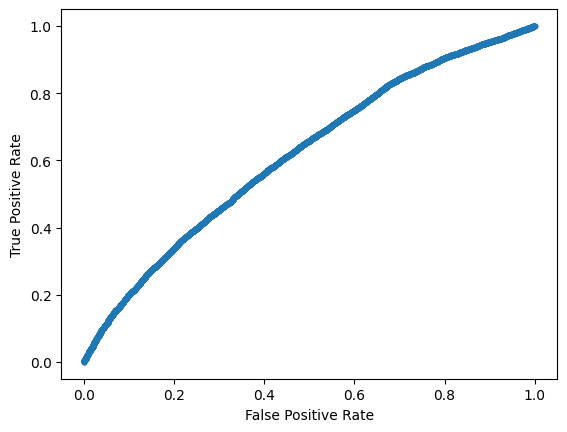

Accuracy: 58.04% Precision: 58.19% Recall: 45.56%
F1: 51.10% MCC: 0.1565
AUPRC: 58.66% AUROC: 61.71%
 accuracy [58.04142552543405]
 precision [58.18935030817419]
 recall [45.55810458033383]
 F1 [51.10480078090336]
 MCC [0.1565483389860126]
 AUPRC [58.65771154405406]
 AUROC [61.71235646811839]

Training # 1 3
2023-05-01 16:49:23.016437
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.3.validation_genes.txt
Discriminator ZERO 0
Train 1:0 48262:57545 45.61%
Computed class weights: {0: 0.9193413850030411, 1: 1.0961729725249678}
Valid 1:0 11772:13634 46.34%
FIT


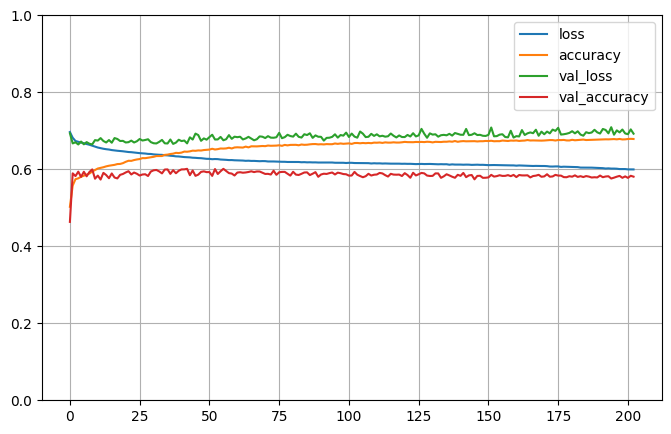


Testing # 1 3
2023-05-01 18:05:50.485481
PREDICT
Test 1:0 11772:13634 46.34%
Predict 1:0 10407:14999 40.96%
Test sizes (25406, 1025) (25406,)
Distrib of scores: 0.4831758 mean 0.1917086 std
Range of scores: 0.12525186 to 0.8643642
Score threshold 0.5
Confusion matrix
 [[9148 4486]
 [5851 5921]]
Normalized matrix
 [[0.36007242 0.17657246]
 [0.23029993 0.23305518]]
Extreme scores correct, pos:neg 3618 3823
Extreme scores incorrect pos:neg 2439 1560


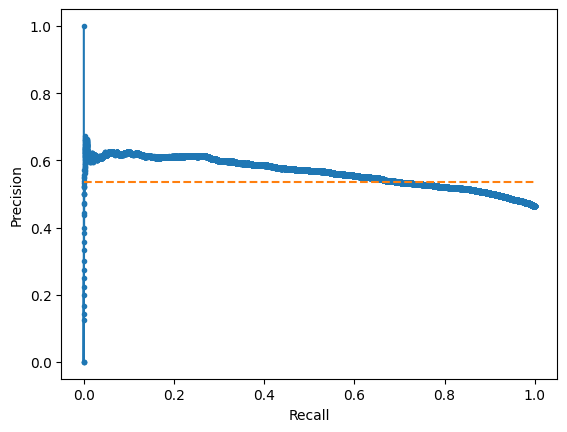

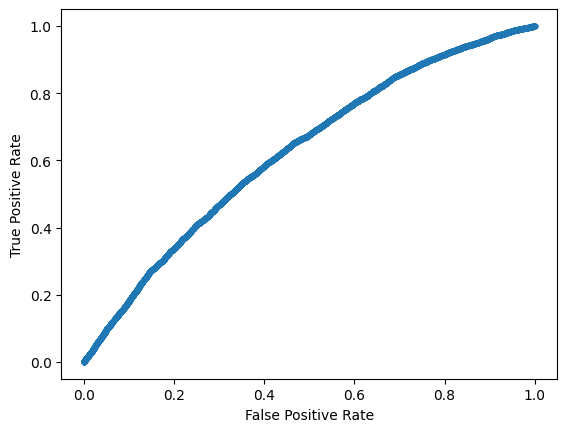

Accuracy: 59.31% Precision: 56.89% Recall: 50.30%
F1: 53.39% MCC: 0.1764
AUPRC: 56.37% AUROC: 62.66%
 accuracy [59.31276076517358]
 precision [56.894398001345245]
 recall [50.29731566428814]
 F1 [53.392849091482944]
 MCC [0.1763799750844476]
 AUPRC [56.374270163164866]
 AUROC [62.6634750170605]

Training # 1 4
2023-05-01 18:05:55.333056
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.4.validation_genes.txt
Discriminator ZERO 0
Train 1:0 48433:56766 46.04%
Computed class weights: {0: 0.9266021914526301, 1: 1.0860260566142919}
Valid 1:0 11601:14413 44.60%
FIT


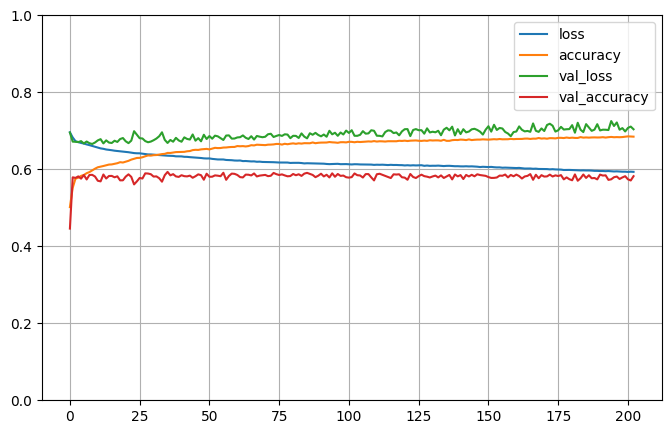


Testing # 1 4
2023-05-01 19:19:04.207780
PREDICT
Test 1:0 11601:14413 44.60%
Predict 1:0 10677:15337 41.04%
Test sizes (26014, 1025) (26014,)
Distrib of scores: 0.4738795 mean 0.1849018 std
Range of scores: 0.059730902 to 0.84716606
Score threshold 0.5
Confusion matrix
 [[9531 4882]
 [5806 5795]]
Normalized matrix
 [[0.36637964 0.18766818]
 [0.22318751 0.22276467]]
Extreme scores correct, pos:neg 3470 4396
Extreme scores incorrect pos:neg 2517 1926


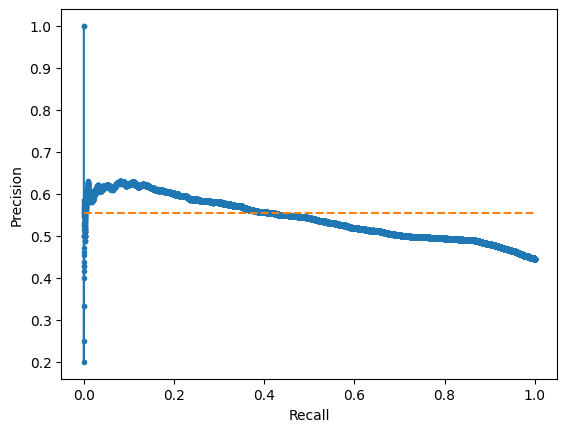

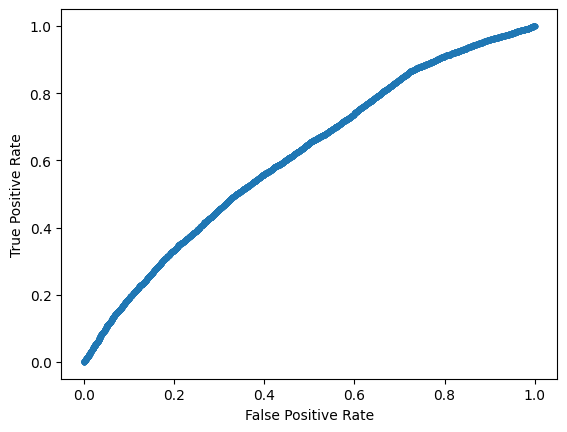

Accuracy: 58.91% Precision: 54.28% Recall: 49.95%
F1: 52.02% MCC: 0.1625
AUPRC: 54.20% AUROC: 61.39%
 accuracy [58.914430691166295]
 precision [54.275545565233685]
 recall [49.95259029394018]
 F1 [52.02441870904031]
 MCC [0.16249002178416883]
 AUPRC [54.202473190124564]
 AUROC [61.390654727971906]

Training # 1 5
2023-05-01 19:19:08.166693
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.5.validation_genes.txt
Discriminator ZERO 0
Train 1:0 48058:56494 45.97%
Computed class weights: {0: 0.925337203950862, 1: 1.0877689458570894}
Valid 1:0 11976:14685 44.92%
FIT


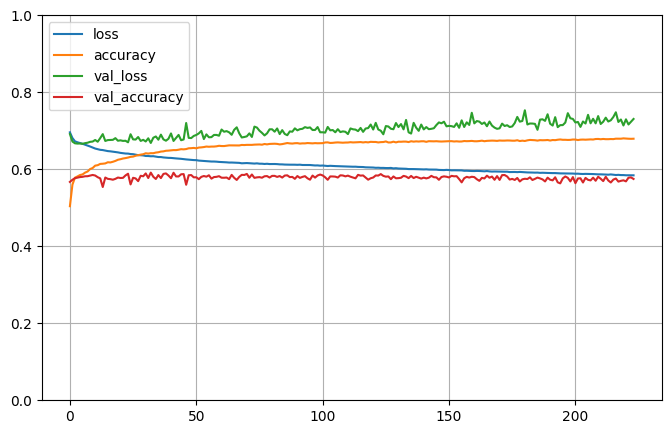


Testing # 1 5
2023-05-01 20:37:37.295565
PREDICT
Test 1:0 11976:14685 44.92%
Predict 1:0 9450:17211 35.45%
Test sizes (26661, 1025) (26661,)
Distrib of scores: 0.45788673 mean 0.19530314 std
Range of scores: 0.036215004 to 0.97329056
Score threshold 0.5
Confusion matrix
 [[10449  4236]
 [ 6762  5214]]
Normalized matrix
 [[0.39192078 0.15888376]
 [0.2536289  0.19556656]]
Extreme scores correct, pos:neg 2896 5003
Extreme scores incorrect pos:neg 2020 2564


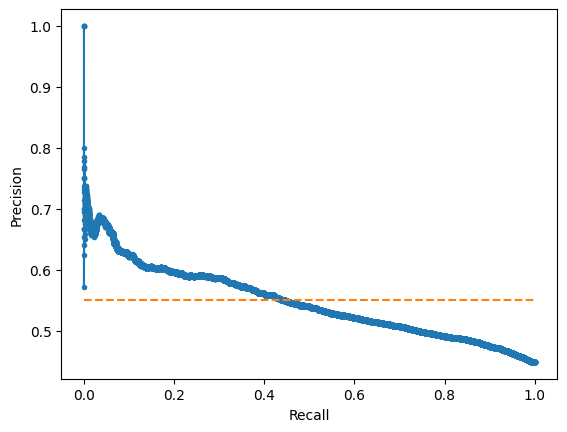

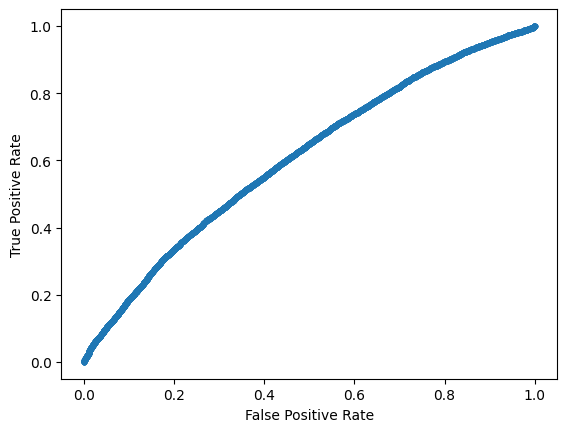

Accuracy: 58.75% Precision: 55.17% Recall: 43.54%
F1: 48.67% MCC: 0.1528
AUPRC: 54.72% AUROC: 60.86%
 accuracy [58.74873410599753]
 precision [55.17460317460318]
 recall [43.5370741482966]
 F1 [48.669840380845706]
 MCC [0.15276875137638196]
 AUPRC [54.717913693714536]
 AUROC [60.85663808606885]

Training # 2 1
2023-05-01 20:37:41.536164
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.1.validation_genes.txt
Discriminator ZERO 0
Train 1:0 47818:57427 45.43%
Computed class weights: {0: 0.9163372629599318, 1: 1.1004747166339035}
Valid 1:0 12216:13752 47.04%
FIT


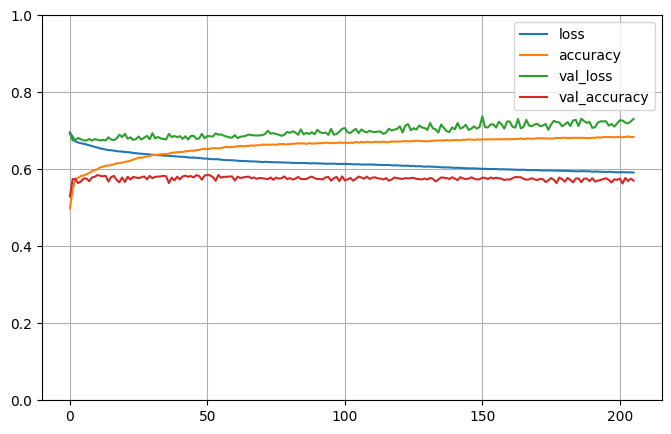


Testing # 2 1
2023-05-01 21:49:08.226093
PREDICT
Test 1:0 12216:13752 47.04%
Predict 1:0 10904:15064 41.99%
Test sizes (25968, 1025) (25968,)
Distrib of scores: 0.4745814 mean 0.18382266 std
Range of scores: 0.05525895 to 0.85818505
Score threshold 0.5
Confusion matrix
 [[8967 4785]
 [6097 6119]]
Normalized matrix
 [[0.34530961 0.18426525]
 [0.23478897 0.23563617]]
Extreme scores correct, pos:neg 3470 3710
Extreme scores incorrect pos:neg 2346 1792


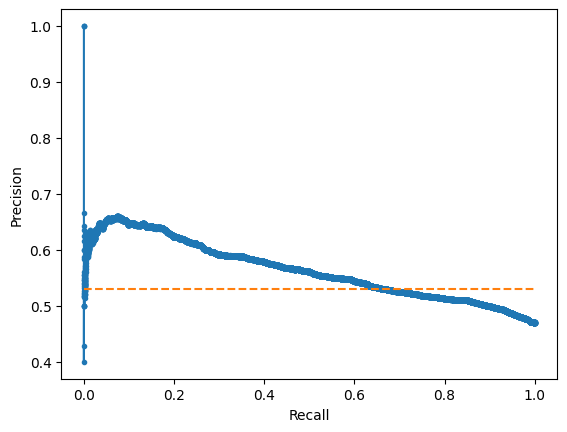

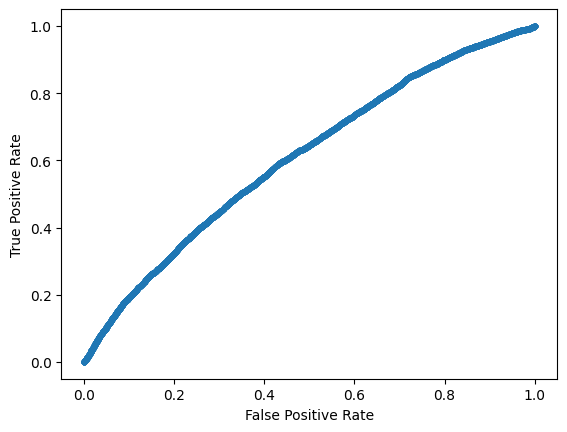

Accuracy: 58.09% Precision: 56.12% Recall: 50.09%
F1: 52.93% MCC: 0.1547
AUPRC: 56.42% AUROC: 60.87%
 accuracy [58.09457794208256]
 precision [56.11702127659575]
 recall [50.09004584151931]
 F1 [52.932525951557096]
 MCC [0.1546809698015897]
 AUPRC [56.41658301018171]
 AUROC [60.872168072808506]

Training # 2 2
2023-05-01 21:49:11.918055
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.2.validation_genes.txt
Discriminator ZERO 0
Train 1:0 48151:56645 45.95%
Computed class weights: {0: 0.9250242739871127, 1: 1.0882016988224543}
Valid 1:0 11883:14534 44.98%
FIT


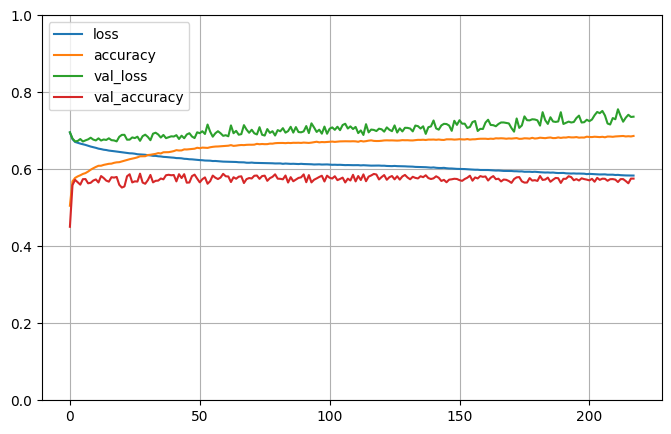


Testing # 2 2
2023-05-01 23:04:37.596380
PREDICT
Test 1:0 11883:14534 44.98%
Predict 1:0 10329:16088 39.10%
Test sizes (26417, 1025) (26417,)
Distrib of scores: 0.46568444 mean 0.1974723 std
Range of scores: 0.06034839 to 0.847712
Score threshold 0.5
Confusion matrix
 [[9868 4666]
 [6220 5663]]
Normalized matrix
 [[0.37354734 0.17662869]
 [0.23545444 0.21436953]]
Extreme scores correct, pos:neg 3464 4043
Extreme scores incorrect pos:neg 2673 1863


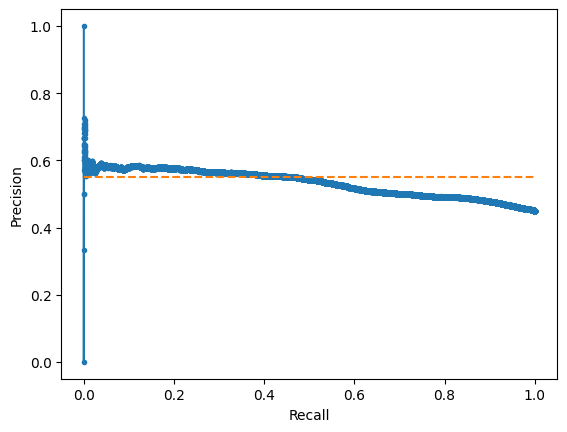

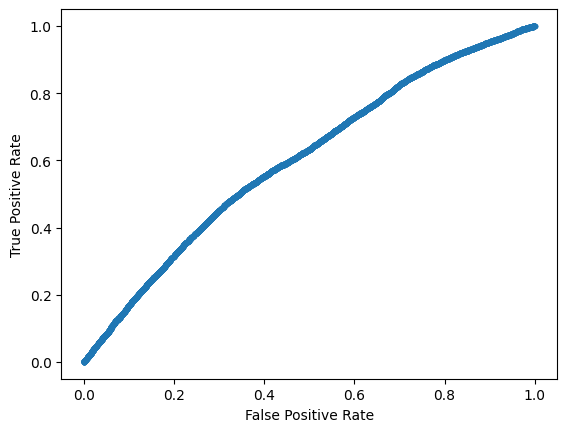

Accuracy: 58.79% Precision: 54.83% Recall: 47.66%
F1: 50.99% MCC: 0.1586
AUPRC: 53.23% AUROC: 60.28%
 accuracy [58.79168717113979]
 precision [54.82621744602575]
 recall [47.65631574518219]
 F1 [50.99045560958041]
 MCC [0.158551236109838]
 AUPRC [53.22871743803679]
 AUROC [60.27999405839428]

Training # 2 3
2023-05-01 23:04:41.474805
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.3.validation_genes.txt
Discriminator ZERO 0
Train 1:0 47715:57343 45.42%
Computed class weights: {0: 0.916049038243552, 1: 1.1008907052289636}
Valid 1:0 12319:13836 47.10%
FIT


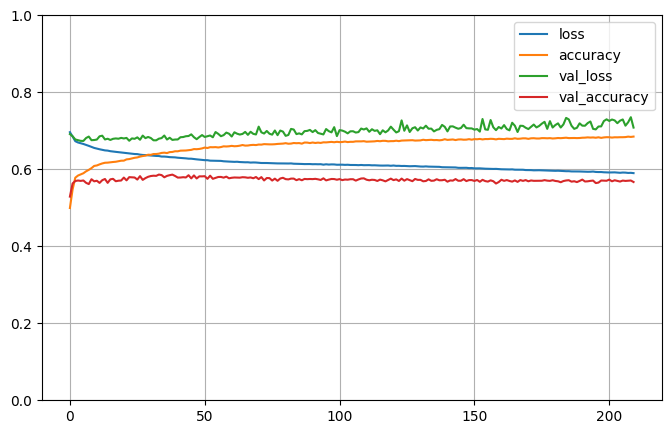


Testing # 2 3
2023-05-02 00:17:09.920032
PREDICT
Test 1:0 12319:13836 47.10%
Predict 1:0 11907:14248 45.52%
Test sizes (26155, 1025) (26155,)
Distrib of scores: 0.49930254 mean 0.1946001 std
Range of scores: 0.06372667 to 0.8714129
Score threshold 0.5
Confusion matrix
 [[8503 5333]
 [5745 6574]]
Normalized matrix
 [[0.32510036 0.20389983]
 [0.21965207 0.25134773]]
Extreme scores correct, pos:neg 4232 3331
Extreme scores incorrect pos:neg 3153 1541


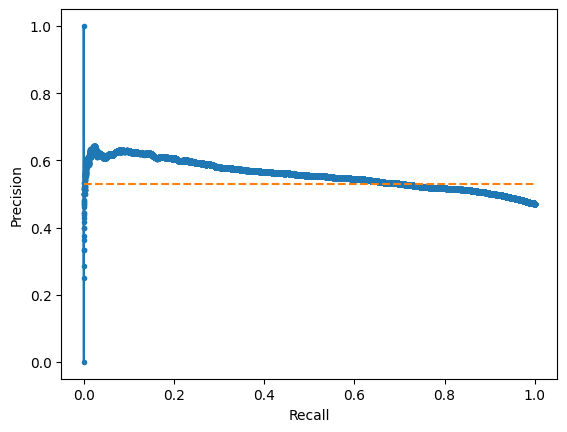

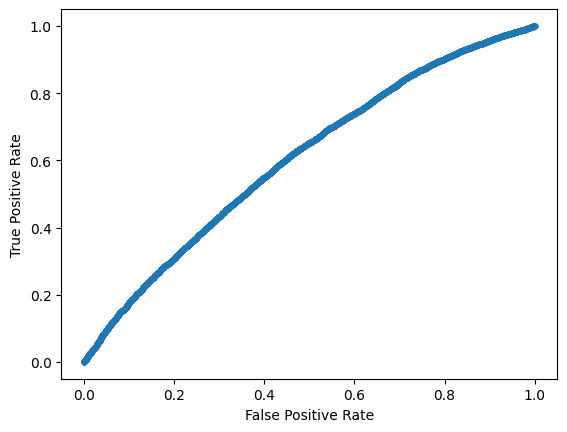

Accuracy: 57.64% Precision: 55.21% Recall: 53.36%
F1: 54.27% MCC: 0.1486
AUPRC: 55.62% AUROC: 60.59%
 accuracy [57.644809787803474]
 precision [55.21122029058537]
 recall [53.36472116243202]
 F1 [54.2722694625609]
 MCC [0.14855017360422879]
 AUPRC [55.624388464571574]
 AUROC [60.58889734045716]

Training # 2 4
2023-05-02 00:17:14.337047
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.4.validation_genes.txt
Discriminator ZERO 0
Train 1:0 47769:56926 45.63%
Computed class weights: {0: 0.9195710220285985, 1: 1.0958466788084322}
Valid 1:0 12265:14253 46.25%
FIT


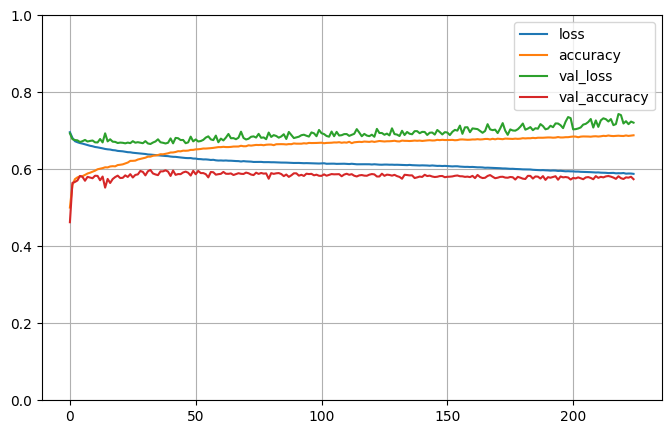


Testing # 2 4
2023-05-02 01:38:40.704796
PREDICT
Test 1:0 12265:14253 46.25%
Predict 1:0 10032:16486 37.83%
Test sizes (26518, 1025) (26518,)
Distrib of scores: 0.4721361 mean 0.19919936 std
Range of scores: 0.08324176 to 0.8440999
Score threshold 0.5
Confusion matrix
 [[9914 4339]
 [6572 5693]]
Normalized matrix
 [[0.37385927 0.16362471]
 [0.24783166 0.21468437]]
Extreme scores correct, pos:neg 3760 4130
Extreme scores incorrect pos:neg 2601 1821


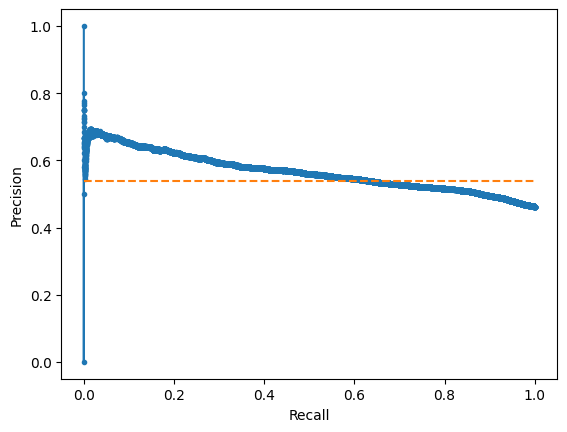

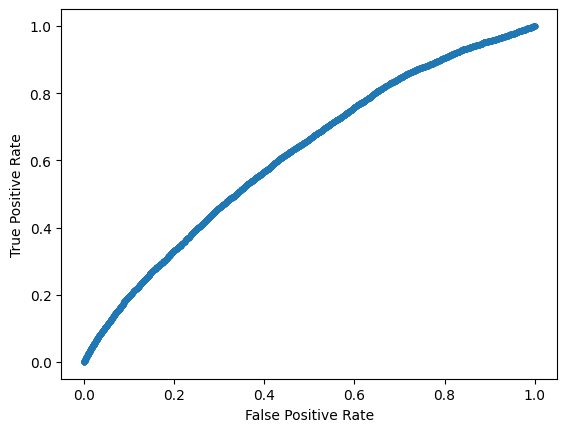

Accuracy: 58.85% Precision: 56.75% Recall: 46.42%
F1: 51.07% MCC: 0.1642
AUPRC: 56.58% AUROC: 61.88%
 accuracy [58.85436307413832]
 precision [56.74840510366826]
 recall [46.4166326946596]
 F1 [51.06516571736108]
 MCC [0.16422791680117055]
 AUPRC [56.58148669362924]
 AUROC [61.87963546999596]

Training # 2 5
2023-05-02 01:38:45.839893
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.5.validation_genes.txt
Discriminator ZERO 0
Train 1:0 48683:56375 46.34%
Computed class weights: {0: 0.9317782705099779, 1: 1.0790008832652056}
Valid 1:0 11351:14804 43.40%
FIT


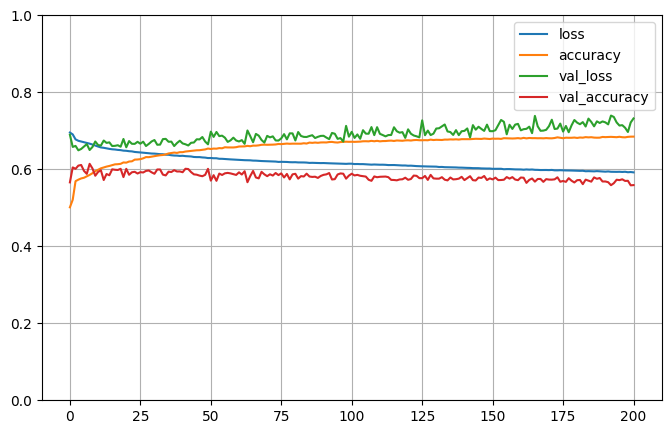


Testing # 2 5
2023-05-02 02:48:13.413958
PREDICT
Test 1:0 11351:14804 43.40%
Predict 1:0 10751:15404 41.10%
Test sizes (26155, 1025) (26155,)
Distrib of scores: 0.49199614 mean 0.20679946 std
Range of scores: 0.06971534 to 0.92004836
Score threshold 0.5
Confusion matrix
 [[9722 5082]
 [5682 5669]]
Normalized matrix
 [[0.37170713 0.19430319]
 [0.21724336 0.21674632]]
Extreme scores correct, pos:neg 3933 4132
Extreme scores incorrect pos:neg 3229 1330


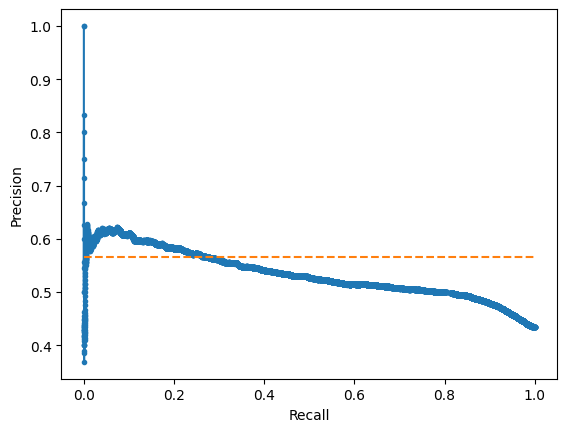

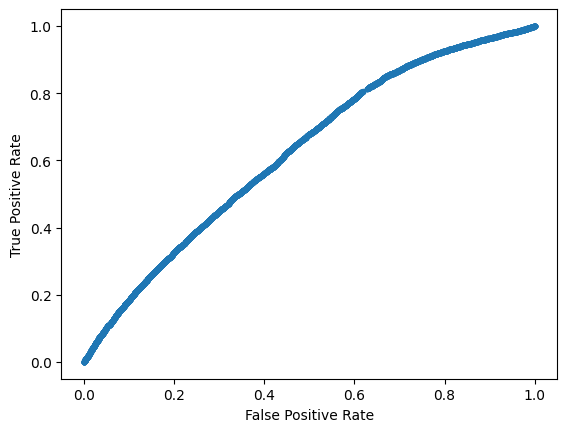

Accuracy: 58.85% Precision: 52.73% Recall: 49.94%
F1: 51.30% MCC: 0.1573
AUPRC: 53.35% AUROC: 62.51%
 accuracy [58.84534505830625]
 precision [52.72997860664125]
 recall [49.94273632279094]
 F1 [51.29852502036015]
 MCC [0.157283982686627]
 AUPRC [53.34831872687526]
 AUROC [62.509834253712285]
2023-05-02 02:48:16.770537


In [7]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader(K,ALPHABET)
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader(K,ALPHABET)
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        builder = ModelBuilder(ALPHABET)
        cvdo = CrossValidator(EPOCHS,RCI_THRESHOLD_VALUE)
        cvdo.set_model_builder(builder)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator('pc')  # use pc filename prefix for mRNA
            separator.set_middle(FILTER_TEST,FILTER_TAILS_TEST,FILTER_MIDDLE_TEST,\
                                 FILTER_TRAIN,FILTER_TAILS_TRAIN,FILTER_MIDDLE_TRAIN,\
                                 MIDDLE_LOW,MIDDLE_HIGH)
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename1 = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                filename2 = f"{SAVE_DESCRIM_FILENAME}.{show_r}.{show_f}.pickle"
                model,discrim = cvdo.get_models()
                save_model(model,discrim,filename1,filename2)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            if LOAD_MODEL_FILENAME is not None:
                filename1 = LOAD_MODEL_FILENAME
                filename2 = LOAD_DESCRIM_FILENAME
                model, descrim = load_model(filename1, filename2)
                cvdo.set_models(model, descrim)
            else:
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [8]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.51% std 0.55
 precision mean 55.38% std 1.64
 recall mean 48.17% std 3.05
 F1 mean 51.46% std 1.80
 MCC mean 0.1568 std 0.0103
 AUPRC mean 55.17% std 1.90
 AUROC mean 61.25% std 0.96
 accuracy [[57.88670537442311], [58.04142552543405], [59.31276076517358], [58.914430691166295], [58.74873410599753], [58.09457794208256], [58.79168717113979], [57.644809787803474], [58.85436307413832], [58.84534505830625]]
 precision [[53.612845673505795], [58.18935030817419], [56.894398001345245], [54.275545565233685], [55.17460317460318], [56.11702127659575], [54.82621744602575], [55.21122029058537], [56.74840510366826], [52.72997860664125]]
 recall [[44.91032879442046], [45.55810458033383], [50.29731566428814], [49.95259029394018], [43.5370741482966], [50.09004584151931], [47.65631574518219], [53.36472116243202], [46.4166326946596], [49.94273632279094]]
 F1 [[48.87724212714047], [51.10480078090336], [53.392849091482944], [52.02441870904031], [48.669840380845706], [52.932525951557096], 